In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind

In [3]:
cases = pd.read_csv('covid_confirmed_usafacts.csv')
population_data = pd.read_csv("covid_county_population_usafacts.csv")

In [5]:
def state_weekly_stats(dataframe, state_name):
    state_deaths = dataframe[dataframe['State'] == state_name]
    state_columns = state_deaths.iloc[:, :4]
    
    # Select date columns only
    state_deaths_only = state_deaths.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'])
    # Make sure dates are in datetime format
    state_deaths_only.columns = pd.to_datetime(state_deaths_only.columns, format='%Y-%m-%d', errors='coerce')

    state_deaths_only = state_deaths_only.loc[:, (state_deaths_only.columns >= '2020-06-01') & (state_deaths_only.columns <= '2021-01-03')]
    
    # Empty DataFrame to hold stats
    weekly_death_stats = pd.DataFrame()
    
    # Create weekly date ranges
    weekly_groups = pd.date_range(start='2020-06-01', end='2021-01-03', freq='W-SUN')

    # For loop to iterate over weeks and calculate stats for deaths
    for i, week_end in enumerate(weekly_groups):
        # Select the date range for the week
        week_start = week_end - pd.Timedelta(days=6)

        # Select the columns corresponding to the week
        week_columns_deaths = state_deaths_only.loc[:, (state_deaths_only.columns >= week_start) & (state_deaths_only.columns <= week_end)]
        
        # Calculate mean, median, and mode for each county (row) across the week (columns)
        weekly_death_mean = week_columns_deaths.mean(axis=1)
        weekly_death_median = week_columns_deaths.median(axis=1)
        weekly_death_mode = week_columns_deaths.mode(axis=1)[0]  # Pick the first mode 

        # Store the results in the DataFrame
        weekly_death_stats[f'week_{i+1}_mean'] = weekly_death_mean
        weekly_death_stats[f'week_{i+1}_median'] = weekly_death_median
        weekly_death_stats[f'week_{i+1}_mode'] = weekly_death_mode

    weekly_death_stats = pd.concat([state_columns, weekly_death_stats], axis=1)

    
    return weekly_death_stats

In [7]:
def top_counties_helper(state):
    type = 'case'
    state_cases = state_weekly_stats(cases, state)
    if (type == 'case'):
        columns = state_cases.columns
        new = pd.DataFrame(state_cases.loc[:,'County Name'])
        for column in columns:
            if 'mean' in column:
                col = state_cases.loc[:,column]
                new = new.join(col)
        return new

In [9]:
def top_counties (state):
    data = top_counties_helper(state)
    new = pd.DataFrame(data.loc[:,'County Name'])
    new['Average'] = None
    size = new['County Name'].size +1
    for x in range(1,size,1):
        new.iloc[x-1,1] = np.average(data.iloc[x-1:x,1:size])
        df = new.sort_values(by='Average',ascending=False).iloc[0:5,:]       
    return df

Normalize the data before use

In [18]:
weekly_case_stats = state_weekly_stats(cases, 'FL')
weekly_case_stats['County Name'] = weekly_case_stats['County Name'].str.strip().str.upper()
weekly_case_stats['State'] = weekly_case_stats['State'].str.strip().str.upper()

population_data['County Name'] = population_data['County Name'].str.strip().str.upper()
population_data['State'] = population_data['State'].str.strip().str.upper()

#Merge dataframes
weekly_case_stats = weekly_case_stats.merge(population_data[['County Name', 'State', 'population']], on=['County Name', 'State'], how='left')

# Loop through each weekly mean column and normalize by population
for i in range(1, 32):  # assuming there are 31 weeks
    weekly_column = f'week_{i}_mean'
    normalized_column = f'week_{i}_normalized'
    
    # Calculate cases per 100,000 people and add a new column
    weekly_case_stats[normalized_column] = (weekly_case_stats[weekly_column] / weekly_case_stats['population']) * 100000

weekly_case_stats = weekly_case_stats[~((weekly_case_stats['County Name'] == 'STATEWIDE UNALLOCATED') & (weekly_case_stats['State'] == 'FL'))]

In [20]:
def modeling(county_name):
    # Filter data for the specified county
    county_data = weekly_case_stats[weekly_case_stats['County Name'].str.contains(county_name, case=False, na=False)]
    
    # Set up X as day numbers instead of week numbers, with each week corresponding to an increment of 7 days
    X = np.arange(1, 32) * 7  # Days starting from June 1, 2020 (days 1, 8, 15, ..., 211 for 31 weeks)
    X = X.reshape(-1, 1)  # Reshape to 2D array for sklearn
    Y = county_data.filter(like='_normalized').values.flatten()  # Flatten to 1D array for regression

    # Linear Regression Model
    linear_model = LinearRegression()
    linear_model.fit(X, Y)
    Y_pred_linear = linear_model.predict(X)

    # Polynomial Regression Model (degree 4)
    degree = 4
    poly_features = PolynomialFeatures(degree)
    X_poly = poly_features.fit_transform(X)
    
    poly_model = LinearRegression()
    poly_model.fit(X_poly, Y)
    Y_pred_poly = poly_model.predict(X_poly)
    
    # Extend X for forecasting (add one extra week)
    X_extended = np.arange(1, 33) * 7  # Days for 32 weeks (extends to day 218)
    X_extended = X_extended.reshape(-1, 1)
    X_poly_extended = poly_features.fit_transform(X_extended)
    Y_pred_linear_extended = linear_model.predict(X_extended)
    Y_pred_poly_extended = poly_model.predict(X_poly_extended)

    # Calculate confidence intervals for polynomial predictions
    residuals = Y - Y_pred_poly
    residual_std = np.std(residuals)
    ci = 1.96 * residual_std  # 95% confidence interval

    plt.figure(figsize=(10, 6))

    # Plot actual data points
    plt.scatter(X, Y, color='blue', label='Actual Data')
    
    # Plot the linear regression trend line (including forecast)
    plt.plot(X_extended, Y_pred_linear_extended, color='red', linestyle='--', label='Linear Regression Forecast')

    # Plot the polynomial regression trend line (including forecast)
    plt.plot(X_extended, Y_pred_poly_extended, color='green', linestyle='--', label=f'Polynomial Regression (Degree {degree}) Forecast')

    # Plot confidence intervals for polynomial predictions
    plt.fill_between(X_extended.flatten(), Y_pred_poly_extended - ci, Y_pred_poly_extended + ci, 
                     color='green', alpha=0.2, label='95% Confidence Interval')

    # Adjust x-axis to display days
    plt.xlabel('Number of Days starting at 2020-06-01')
    plt.ylabel('Weekly Mean Cases per 100,000 People')
    plt.title(f'COVID-19 Trend with Forecast and Confidence Interval in {county_name}')
    plt.legend()
    
    # Show the plot
    plt.show()

    # Calculate and print RMSE for polynomial model
    rmse_poly = np.sqrt(mean_squared_error(Y, Y_pred_poly))
    print(f"Polynomial Regression (Degree {degree}) RMSE for {county_name}: {rmse_poly}")

##### Get top Counties for florida

In [12]:
top_counties ('FL')

,County Name,Average
372,Miami-Dade County,153109.529954
335,Broward County,70521.506912
379,Palm Beach County,43258.465438
357,Hillsborough County,38605.437788
377,Orange County,37492.663594


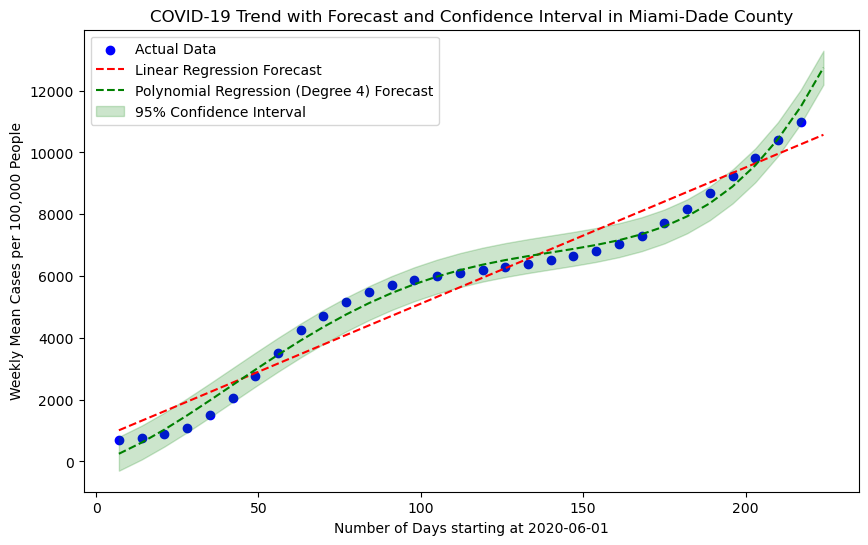

Polynomial Regression (Degree 4) RMSE for Miami-Dade County: 279.91983941157554


In [25]:
modeling ('Miami-Dade County')

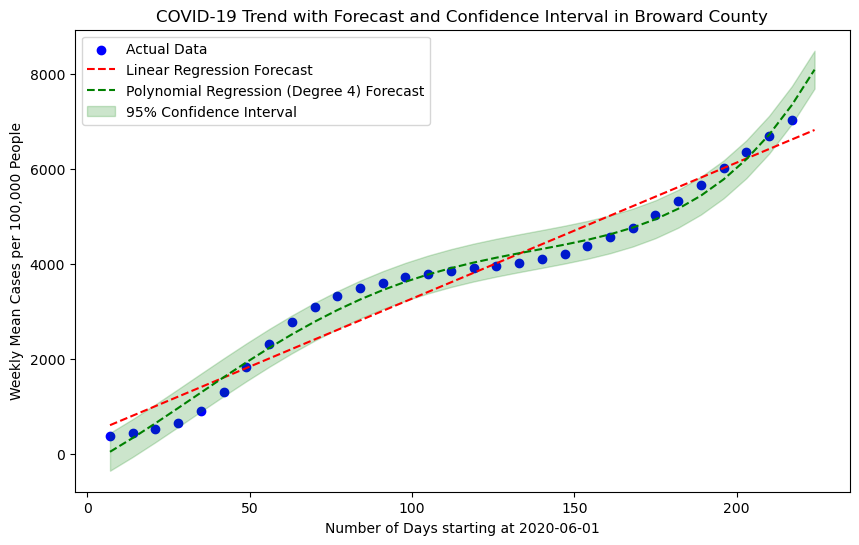

Polynomial Regression (Degree 4) RMSE for Broward County: 203.4753877263748


In [27]:
modeling ('Broward County')

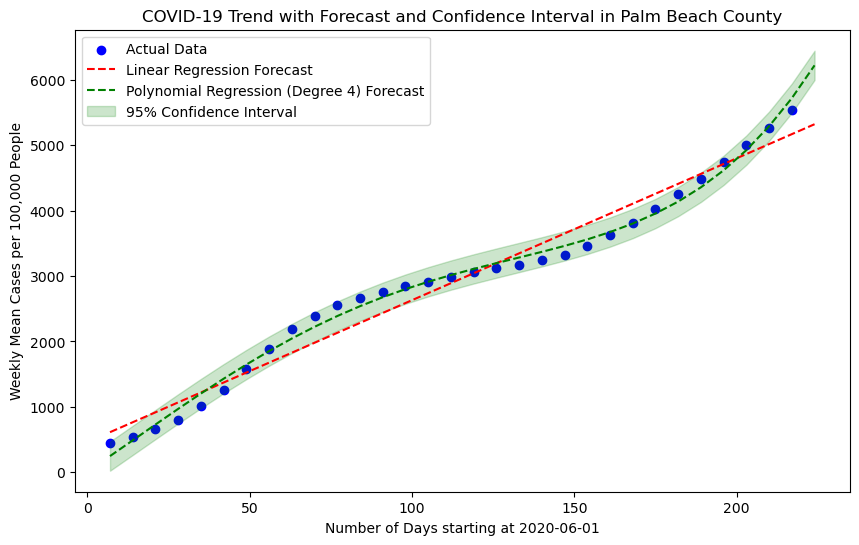

Polynomial Regression (Degree 4) RMSE for Palm Beach County: 114.03505498563844


In [29]:
modeling ('Palm Beach County')

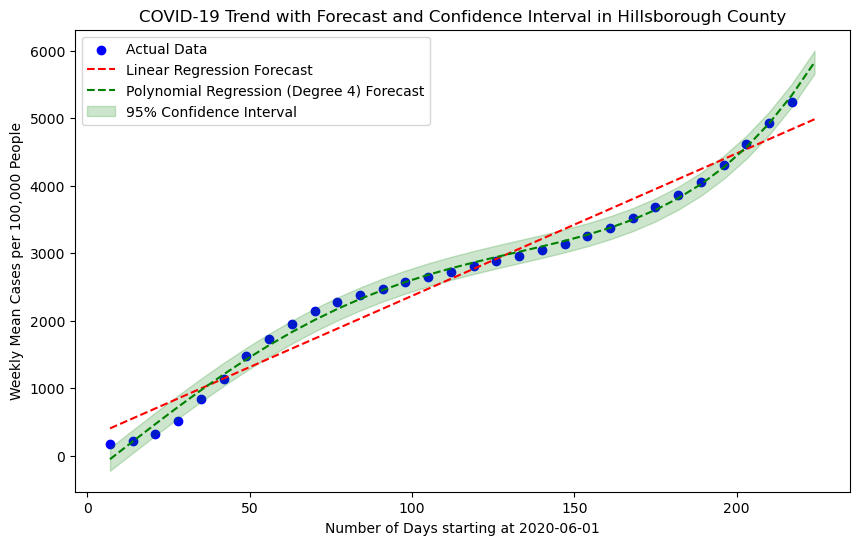

Polynomial Regression (Degree 4) RMSE for Hillsborough County: 86.95136953278417


In [31]:
modeling ('Hillsborough County')

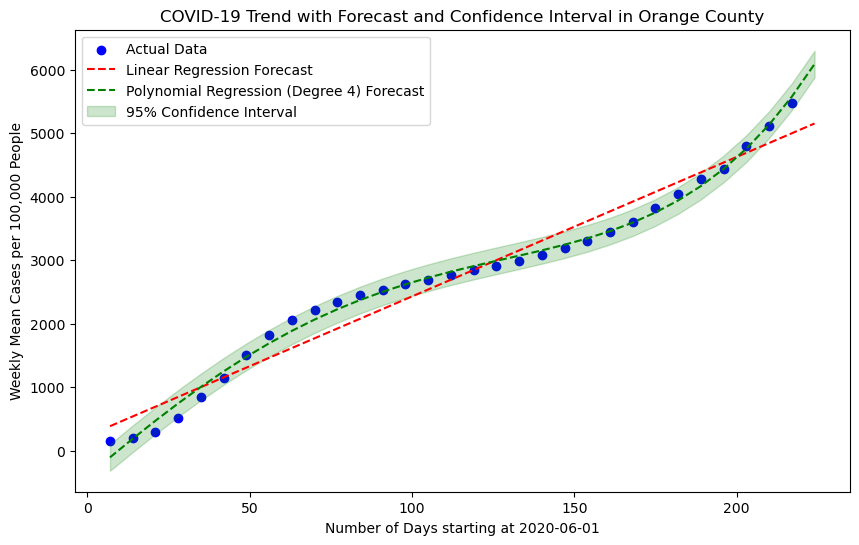

Polynomial Regression (Degree 4) RMSE for Orange County: 107.31832259950585


In [33]:
modeling ('Orange County')

#### Describing the Trends:
For each County, the trends are really similar. They all spike up near the end. Especially for Miami-Dade and Broward County. They had the most cases per 100,000 people

# Hypothesis Testing

#### Hypothesis 1: Did the Number of New Cases Decrease as the Pandemic Progressed?
##### H0 Null Hypothesis: The average number of new COVID-19 cases did not decrease over time.
##### H1 Alternative Hypothesis: The average number of new COVID-19 cases decreased as the pandemic progressed.

In [70]:
test = cases[cases['State'] == 'FL']
test.head(3)

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2023-07-14,2023-07-15,2023-07-16,2023-07-17,2023-07-18,2023-07-19,2023-07-20,2023-07-21,2023-07-22,2023-07-23
329,0,Statewide Unallocated,FL,12,0,0,0,0,0,0,...,20363,20363,20363,20363,20363,20363,20363,20363,20363,20363
330,12001,Alachua County,FL,12,0,0,0,0,0,0,...,90634,90634,90634,90634,90634,90634,90634,90634,90634,90634
331,12003,Baker County,FL,12,0,0,0,0,0,0,...,10787,10787,10787,10787,10787,10787,10787,10787,10787,10787


In [72]:
 # Select date columns only
test = test.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'])
# Make sure dates are in datetime format
test.columns = pd.to_datetime(test.columns, format='%Y-%m-%d', errors='coerce')
test = test.loc[:, (test.columns >= '2020-06-01') & (test.columns <= '2021-01-03')]
test.head(3)

,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,...,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31,2021-01-01,2021-01-02,2021-01-03
329,84,87,89,90,95,97,97,93,93,96,...,3036,3067,3080,3088,3082,3062,3010,3010,3045,3065
330,382,382,383,387,392,396,399,399,404,412,...,15182,15370,15420,15473,15574,15674,15866,15866,16230,16335
331,29,29,29,29,29,29,29,29,29,29,...,2374,2395,2397,2414,2432,2453,2470,2470,2527,2544


In [74]:
#Split the current date range into 'early' and 'later' in the pandemic using a middle date
early_period = test.loc[:, test.columns <= '2020-09-16']
late_period = test.loc[:,test.columns > '2020-09-16']

#next sum up the values across all rows (counties) to perform t stats
early = early_period.sum(axis=0)
late = late_period.sum(axis=0)

#tstats
t_stat, p_value = ttest_ind(early, late, equal_var=False)
print("T-test for New Cases Over Time")
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-test for New Cases Over Time
T-statistic: -18.86005494801259
P-value: 2.8708403669604097e-47


#### Interpretation
##### P-value (0.0): Because the p-value is below the typical threshold of 0.05, it allows us to reject the null hypothesis. This suggesting that there IS a statistically significant difference in the average daily COVID-19 cases between the two time periods.
##### T-statistic (-58.95): This negative t-statistic tells us that the average number of new cases in the later period is lower than in the early period.  Because the T-statistic is so large, this emphisizes a more substantial difference
##### Based on these results, we can conclude that: The number of new cases significantly decreased as the pandemic progressed.

#### Hypothesis 2: Are Counties with Higher Percentages of Low-Income Households More Negatively Affected?
##### Null Hypothesis (H0): There is no difference in COVID-19 cases between counties with high and low percentages of low-income households.
##### Alternative Hypothesis (H1): Counties with higher percentages of low-income households are more negatively affected by COVID-19

In [78]:
income_data = pd.read_csv('2020FloridaIncomeData.csv')
#setting up the lower income brackets, for simplicity we are sumply dividing the brackets in half
low_income_columns = [
    'Less than $10,000', 
    '$10,000 to $14,999', 
    '$15,000 to $24,999', 
    '$25,000 to $34,999', 
    '$35,000 to $49,999'
]

income_data[low_income_columns + ['Total']] = income_data[low_income_columns + ['Total']].replace(',', '', regex=True).astype(int)
income_data['low_income_count'] = income_data[low_income_columns].sum(axis=1)
income_data['low_income_percentage'] = (income_data['low_income_count'] / income_data['Total']) * 100

#Next Merge both datasets on county name
merge = cases[cases['State'] == 'FL']

# keep 'County Name' and drop other nopt needed columns
county_name_column = merge['County Name']
merge = merge.drop(columns=['countyFIPS', 'State', 'StateFIPS', 'County Name'])

# Convert only date columns to datetime format
date_columns = pd.to_datetime(merge.columns, format='%Y-%m-%d', errors='coerce')

# Select only the columns within the specified date range
merge = merge.loc[:, (date_columns >= '2020-06-01') & (date_columns <= '2021-01-03')]

# Add 'County Name' column back to the DataFrame
merge.insert(0, 'County Name', county_name_column.values)

# Display the final DataFrame
merge.head()

,County Name,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,...,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31,2021-01-01,2021-01-02,2021-01-03
329,Statewide Unallocated,84,87,89,90,95,97,97,93,93,...,3036,3067,3080,3088,3082,3062,3010,3010,3045,3065
330,Alachua County,382,382,383,387,392,396,399,399,404,...,15182,15370,15420,15473,15574,15674,15866,15866,16230,16335
331,Baker County,29,29,29,29,29,29,29,29,29,...,2374,2395,2397,2414,2432,2453,2470,2470,2527,2544
332,Bay County,99,99,105,111,115,123,130,132,133,...,11124,11302,11358,11403,11540,11753,11907,11907,12132,12261
333,Bradford County,51,51,51,51,52,52,52,52,52,...,2056,2090,2103,2118,2137,2163,2180,2180,2224,2235


In [80]:
# Standardize 'County Name' in both DataFrames by stripping whitespace and converting to lowercase
income_data['County Name'] = income_data['County Name'].str.strip().str.lower()
merge['County Name'] = merge['County Name'].str.strip().str.lower()

In [82]:
# Step 1: Calculate total cases for each county in cases_data
# Assuming the date columns are already filtered and 'County Name' is present
merge['total_cases'] = merge.drop(columns=['County Name']).sum(axis=1)

# Step 2: Merge income_data and cases_data on 'County Name'
merged_data = pd.merge(income_data[['County Name', 'low_income_percentage']], 
                       merge[['County Name', 'total_cases']], 
                       on='County Name')
# Step 3: Split counties into high and low low-income groups based on the median
median_income_threshold = merged_data['low_income_percentage'].median()
high_income_counties = merged_data[merged_data['low_income_percentage'] >= median_income_threshold]
low_income_counties = merged_data[merged_data['low_income_percentage'] < median_income_threshold]
# Step 4: Perform two-sample t-test to compare COVID-19 cases between the two groups
t_stat, p_value = ttest_ind(high_income_counties['total_cases'], low_income_counties['total_cases'], equal_var=False)

# Output the results
print("T-test for Low-Income Households and COVID-19 Cases")
print("T-statistic:", t_stat)
print("P-value:", p_value)

print("High income counties variance:", high_income_counties['total_cases'].var())
print("Low income counties variance:", low_income_counties['total_cases'].var())

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: Counties with higher percentages of low-income households are more negatively affected by COVID-19.")
else:
    print("Fail to reject the null hypothesis: No significant difference in COVID-19 cases based on low-income percentages.")

T-test for Low-Income Households and COVID-19 Cases
T-statistic: -2.761713899733302
P-value: 0.009318301064784627
High income counties variance: 647922476186.3708
Low income counties variance: 39288759762085.055
Reject the null hypothesis: Counties with higher percentages of low-income households are more negatively affected by COVID-19.


#### Results:
##### T-Statistic (-2.76): The negative t-stat tells us that counties with higher percentages of low-income households tend to have higher COVID-19 cases, which aligns with the alternative hypothesis.
##### P-Value (0.0093): This p-value is below a significance level of 0.05, allowing us to reject the null hypothesis. This means there's a statistically significant difference in COVID-19 case counts based on the low-income percentage of counties.
##### Because we rejected the null hypothesis, we can conclude that counties with higher percentages of low-income households ARE more negatively affected by COVID-19 compared to counties with lower percentages of low-income households.